In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import glob
import json
import os


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, f1_score
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, GridSearchCV, learning_curve
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier


import seaborn as sns

from sklearn.model_selection import learning_curve, validation_curve


In [2]:
def read_maneuver_map(path, debug=False):
    # Ensure the path is a string
    if not isinstance(path, str):
        raise ValueError("Path must be a string")
    
    # Check if the file exists
    if not os.path.exists(path):
        raise FileNotFoundError(f"File {path} does not exist")
    
    # Read the JSON file and return as a dictionary
    with open(path, 'r') as json_file:
        data = json.load(json_file)
    
    if debug:
        print(f"Read JSON from {path}: {data}")
    
    return data

# Define high level features that are calculated for each low level feature
# TODO: add more high lvl features
# TODO: attention these do not make sense for categorical data types
HIGH_LVL_FEATURE_FUNCTION_MAP = {
    'Mean' : np.mean, 
    'StdDeviation' : np.std, 
    'Min' : np.min, 
    'Max' : np.max, 
    'Median' : np.median,
    'Variance': np.var
}

# Attention: do only supply numerical values
# Extract high level features for one block (for each low level feature, extract all high level features specified above)
# block_data -> dataframe of values to be summarized in high level features
# high_level_feature_function_map -> each entry in this map will be applied like this:
# create a new col using the key and the function value to the original colums
# this is repeated for each column of the original df -> col * key count (applies func to entire col)
def extract_high_lvl_features(block_data, high_level_feature_function_map=HIGH_LVL_FEATURE_FUNCTION_MAP):
    # Create an empty list to store results
    processed_data = []

    for low_lvl_feature in block_data.columns:
        # For each low-level feature, apply each high-level function
        for prefix, func in high_level_feature_function_map.items():
            # Apply the function to the column and store the result
            processed_data.append(func(block_data[low_lvl_feature]))

    # Convert the processed data into a DataFrame
    processed_block_data = pd.DataFrame(processed_data).T

    # Now, update the columns to have meaningful names like 'Mean_feature1', 'StdDeviation_feature1', etc.
    processed_block_data.columns = [f'{prefix}_{low_lvl_feature}' 
                                    for low_lvl_feature in block_data.columns 
                                    for prefix in high_level_feature_function_map.keys()]

    return processed_block_data

# expects a flight df and transforms with high level features
# block_size is self explanatory
# block_count_ratio is ratio e.g 0.5 of generated blocks in ratio with df length
# e.g with block_size 500 and ratio 0.5 the function generates the amount of blocks that with the block_size covers the block_count_ratio
def get_block_features(data, block_size, block_count_ratio):

    processed_df = pd.DataFrame()
    # represents rounded down amount of blocks to get ratio
    block_count = int(len(data) * block_count_ratio / block_size)
    if block_count < 1:
        raise Exception("the block_size is too big and produces block_count < 1")
    
    # create block_count blocks
    for i in range(block_count):
        # Generate random start index
        start_index = np.random.randint(0, len(data) - block_size + 1)    

        # USE COPY HERE TO PREVENT MULTIPLE processings of same rows
        # Select rows from start index to start index + block size
        block_data_copy_df = data.iloc[start_index:start_index + block_size].copy()   
        single_processed_block_df = extract_high_lvl_features(block_data_copy_df.select_dtypes(include='number'))

        # Find most common category for categorical types in block
        for categorical_column in block_data_copy_df.select_dtypes(include='category').columns:
            most_common_category = block_data_copy_df[categorical_column].value_counts().idxmax()
            single_processed_block_df[categorical_column] = pd.Categorical([most_common_category], categories=block_data_copy_df[categorical_column].cat.categories)

        # add the block to the result
        processed_df = pd.concat([processed_df, single_processed_block_df], ignore_index=True)
    return processed_df.convert_dtypes()


def get_block_rollingwindow_features(data, block_size):
 
    processed_df = pd.DataFrame()
    # represents rounded down amount of blocks to get ratio
    block_count = int(len(data) - block_size)
    if block_count < 1:
        raise Exception("the block_size is too big and produces block_count < 1")
   
    # create block_count blocks
    for i in range(block_count):
        # Generate start index for rolling window
        start_index = i
 
        # USE COPY HERE TO PREVENT MULTIPLE processings of same rows
        # Select rows from start index to start index + block size
        block_data_copy_df = data.iloc[start_index:start_index + block_size].copy()  
        single_processed_block_df = extract_high_lvl_features(block_data_copy_df.select_dtypes(include='number'))
 
        # Find most common category for categorical types in block
        for categorical_column in block_data_copy_df.select_dtypes(include='category').columns:
            most_common_category = block_data_copy_df[categorical_column].value_counts().idxmax()
            single_processed_block_df[categorical_column] = pd.Categorical([most_common_category], categories=block_data_copy_df[categorical_column].cat.categories)
 
        # add the block to the result
        processed_df = pd.concat([processed_df, single_processed_block_df], ignore_index=True)
    return processed_df.convert_dtypes()
 

# loads all pickle files from parsed_data into single df
# features expects python list of feature names to load
# block_size is self explanatory
# block_count_ratio is ratio e.g 0.5 of generated blocks in ratio with df length
# e.g with block_size 500 and ratio 0.5 the function generates the amount of blocks that with the block_size covers the block_count_ratio
#
# further info blocks are create on the basis of specific flies not over the df which contains all data
def training_data(features, block_size, block_count_ratio): 
    df = pd.DataFrame()
    pkl_files = glob.glob(os.path.join('parsed_data', '*.pkl'))

    #print(pkl_files)
    # do only concat cols which are in each pickle
    for i, pkl_file in enumerate(pkl_files):
        # load additional data from file
        additional_df = pd.read_pickle(pkl_file)
        # select wanted features
        additional_df = additional_df[features]
        #######################################################################
        maneuver_df = additional_df['maneuver']
        additional_df = additional_df.select_dtypes(include='number')  #WE DROP ALL THE CATEGORIES since e.g list is hardly usable without further work
        additional_df['maneuver'] = maneuver_df
        maneuver_df = None
        #######################################################################

        # NOW SPLIT INTO BLOCKS
        additional_df = get_block_features(additional_df,block_size,block_count_ratio)

        for col in additional_df.select_dtypes(include='category').columns:
            # this should be in the df except first iteration
            if col in df.columns:
                # create categorical union
                uc = pd.api.types.union_categoricals([df[col], additional_df[col]])
                # give them union categories to both df
                df[col] = pd.Categorical(df[col], categories=uc.categories) 
                additional_df[col] = pd.Categorical(additional_df[col], categories=uc.categories)

        # finally we may concat
        df = pd.concat([df, additional_df], ignore_index=True)

    return df

# loads all pickle files from parsed_data into single df
# features expects python list of feature names to load
# block_size is self explanatory
# block_count_ratio is ratio e.g 0.5 of generated blocks in ratio with df length
# e.g with block_size 500 and ratio 0.5 the function generates the amount of blocks that with the block_size covers the block_count_ratio
#
# further info blocks are create on the basis of specific flies not over the df which contains all data
def test_data(features, block_size): 
    """
    Processes test data by creating non-overlapping blocks starting from the beginning of the dataset.
    Each block is summarized into high-level features.
    
    Args:
        features (list): List of feature names to include.
        block_size (int): Size of each block.
    
    Returns:
        pd.DataFrame: Processed test data with high-level features.
    """
    df = pd.DataFrame()
    pkl_files = glob.glob(os.path.join('parsed_test_data', '*.pkl'))

    print(pkl_files)

    # Iterate through each pickle file to process data
    for i, pkl_file in enumerate(pkl_files):
        # Load data from pickle file
        additional_df = pd.read_pickle(pkl_file)
        
        # Filter for the selected features
        additional_df = additional_df[features]

        # Separate maneuver column to handle it separately
        maneuver_df = additional_df['maneuver']
        additional_df = additional_df.select_dtypes(include='number')  # Drop non-numeric columns
        additional_df['maneuver'] = maneuver_df
        maneuver_df = None

        # Create non-overlapping blocks from the start of the data
        block_count = len(additional_df) // block_size
        if block_count < 1:
            raise Exception(f"Block size {block_size} is too large for the data in {pkl_file}.")
        
        for b in range(block_count):
            # Calculate the start and end indices for the current block
            start_index = b * block_size
            end_index = start_index + block_size
            
            # Extract the block data
            block_data_copy_df = additional_df.iloc[start_index:end_index].copy()

            # Extract high-level features for the block
            single_processed_block_df = extract_high_lvl_features(block_data_copy_df.select_dtypes(include='number'))

            # Find the most common category for categorical columns
            for categorical_column in block_data_copy_df.select_dtypes(include='category').columns:
                most_common_category = block_data_copy_df[categorical_column].value_counts().idxmax()
                single_processed_block_df[categorical_column] = pd.Categorical([most_common_category], categories=block_data_copy_df[categorical_column].cat.categories)

            # Add the block to the result DataFrame
            df = pd.concat([df, single_processed_block_df], ignore_index=True)
    
    return df.convert_dtypes()


# same function as in other file
def plot_maneuver_distribution(data, maneuver_map):
    # Count occurrences of each maneuver
    maneuver_counts = data['maneuver'].value_counts().sort_index()

    # Reverse the maneuver map for readable labels
    reverse_maneuver_map = {v: k for k, v in maneuver_map.items()}
    labeled_index = [reverse_maneuver_map[i] for i in maneuver_counts.index]

    # Create the figure and axis object
    fig, ax = plt.subplots(figsize=(7, 3))

    # Create the bar plot
    ax.bar(labeled_index, maneuver_counts.values)
    ax.set_title("Number of Blocks per Maneuver")
    ax.set_xlabel("Maneuver Number")
    ax.set_ylabel("Count")
    ax.set_xticklabels(labeled_index, rotation=45)

    # Return the figure object to allow further manipulation
    return fig

# same function as in other file
def balance_maneuver_data(data):
     # Count the number of samples for each maneuver category
    maneuver_counts = data['maneuver'].value_counts().sort_index()
    
    # Exclude the "no maneuver" (class 4) from the average calculation
    average_count = maneuver_counts.drop(4).mean()
    n_samples_to_keep = int(np.round(average_count))

    target_class = 4 # Corresponds to "no maneuver" in the maneuver map
    # Split the dataset into the target class (4) and other classes
    df_class_4 = data[data['maneuver'] == target_class]
    df_other = data[data['maneuver'] != target_class]

    # Randomly sample rows
    df_class_4_downsampled = df_class_4.sample(n=n_samples_to_keep, random_state=42)

    return pd.concat([df_class_4_downsampled, df_other], ignore_index=True)

# Determine optimal blocksize

In [3]:
def evaluate_block_size(block_sizes, features, block_count_ratio, k_count=8):
    results = []

    for block_size in block_sizes:
        print(f"Evaluating block size: {block_size}")

        # 1. prepare data
        data = training_data(features,block_size,block_count_ratio)
        balanced_data = balance_maneuver_data(data) # step can be omitted if SVC is configured with class_weight='balanced'

        
        X = data.drop(columns=['maneuver'])
        y = data['maneuver']

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # 2. Apply PCA (automatically guesses how many dimensions to reduce to)
        pca = PCA(n_components='mle', svd_solver='full')
        X_pca = pca.fit_transform(X_scaled)

        # 3. Defining model and k-fold
        model = SVC(class_weight='balanced')
        kf = KFold(n_splits=k_count, shuffle=True, random_state=42)
        
        # 4. Train model using cross validation
        cv_scores = cross_val_score(model, X_pca, y, cv=kf, scoring='accuracy')

        # 5. Record the results
        results.append({
            'block_size': block_size,
            'mean_accuracy': np.mean(cv_scores),
            'std_accuracy': np.std(cv_scores)
        })

    results_df = pd.DataFrame(results)
    return results_df



In [34]:
block_size_range = [400, 600, 800, 1000, 1200, 1500, 2000]
SHARED_FEATURES_LIST = ['MotionPlatform_FreezeAndResumeState', 'Ios_FlightAssistance_ClimbRate_Enabled', 'Ios_FlightAssistance_Pedals_Enabled', 'Aerofly_Out_Aircraft_GroundTrack', 'Aerofly_Out_Instrument_PressureAltitude', 'Aerofly_In_Aircraft_WindShearY', 'Aerofly_Out_Aircraft_Hydraulics_MainRotorServo0Pressure', 'Aerofly_Out_Aircraft_AngularVelocity', 'Ios_FlightAssistance_Stable_ForwardFlight', 'Aerofly_Out_Instrument_RadarAltimeter', 'Aerofly_Out_Aircraft_AngleOfAttack', 'Aerofly_Out_Aircraft_Hydraulics_MainRotorServo2Pressure', 'Aerofly_Out_Aircraft_Hydraulics_TailRotorActuatorPressure', 'Ios_FlightAssistance_Stable_Hover', 'Aerofly_Out_Aircraft_PressureAltitude', 'Aerofly_Out_Aircraft_MagneticHeading', 'Aerofly_Out_Aircraft_TrueAltitude', 'Aerofly_Out_Aircraft_Velocity', 'Aerofly_Out_Aircraft_RawAirTemperature', 'Aerofly_Out_Simulation_Fps', 'Aerofly_Running', 'Aerofly_Out_Aircraft_TrueHeading', 'Cls_MainState', 'Aerofly_Out_Aircraft_AirTemperature', 'Hardware_Controls_HelicopterThrottle', 'Aerofly_Out_Instrument_IndicatedAirspeed', 'Aerofly_In_Aircraft_WindShearX', 'Aerofly_Out_Aircraft_VerticalSpeed', 'Aerofly_Out_Aircraft_Latitude', 'Ios_LoadFactor', 'Ios_FlightAssistance_ForwardSpeed_Enabled', 'Aerofly_Out_Aircraft_Gravity', 'Aerofly_Out_Aircraft_Hydraulics_MainRotorServo1Pressure', 'Ios_FlightAssistance_SideSpeed_Enabled', 'Aerofly_Out_Aircraft_Hydraulics_MainLinePressure', 'MotionPlatform_FsmState', 'Aerofly_Out_Aircraft_Pitch', 'Aerofly_Out_Aircraft_Acceleration', 'Aerofly_Out_Instrument_EngineNP', 'Aerofly_Out_Instrument_GeneratorContactorCurrent', 'Aerofly_Out_Simulation_SelectedTriangles', 'Aerofly_Out_Simulation_Time', 'Aerofly_Out_Simulation_Pause', 'Ios_Weight_Fuel', 'Aerofly_Out_Instrument_EngineNR', 'Aerofly_In_Simulation_Fade', 'Ios_GroundHeight', 'Aerofly_Out_Instrument_EngineTorqueFraction', 'Aerofly_Out_Aircraft_GroundSpeed', 'Aerofly_Out_Aircraft_TrueAirspeed', 'MotionPlatform_Running', 'Aerofly_Out_Aircraft_FuelMass', 'maneuver', 'Aerofly_Out_Aircraft_Altitude', 'CLS_U', 'Aerofly_Out_Aircraft_Bank', 'Aerofly_Out_Aircraft_RotorRotationSpeed', 'Aerofly_Out_Aircraft_SideSlip', 'Aerofly_Out_Instrument_FuelFlow', 'Ios_FlightAssistance_Throttle_Enabled', 'PoseTracking_State', 'Aerofly_Out_Aircraft_Longitude', 'Aerofly_Out_Aircraft_Height']

# Evaluate block sizes
block_size_results = evaluate_block_size(
    block_sizes=block_size_range,
    features=SHARED_FEATURES_LIST,
    block_count_ratio=0.9
)

Evaluating block size: 400
Evaluating block size: 600
Evaluating block size: 800
Evaluating block size: 1000
Evaluating block size: 1200
Evaluating block size: 1500
Evaluating block size: 2000


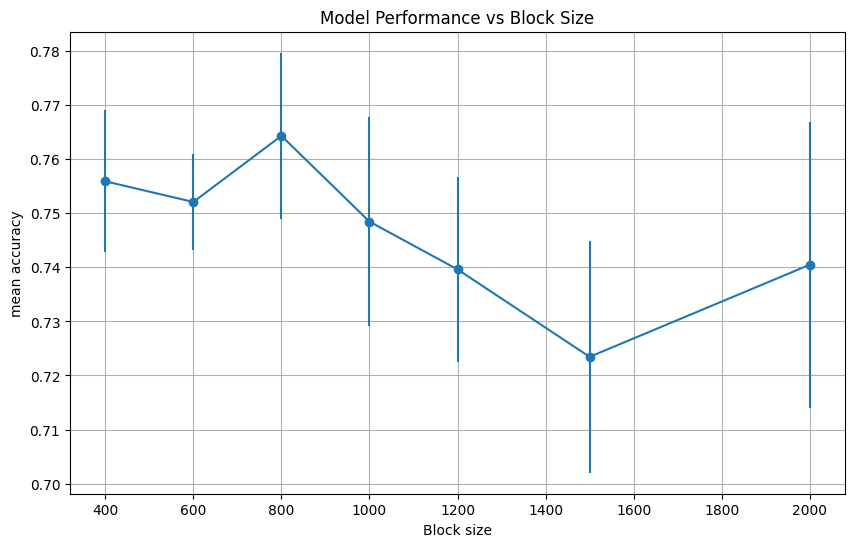

In [40]:
plt.figure(figsize=(10, 6))
plt.errorbar(block_size_results['block_size'], block_size_results['mean_accuracy'],
             yerr=block_size_results['std_accuracy'], fmt='-o')
plt.title('Model Performance vs Block Size')
plt.xlabel("Block size")
plt.ylabel("mean accuracy")
plt.grid()


## Model tuning

In [ ]:
def execute_grid_search(block_size, features, block_count_ratio, k_count=8):

    # 1. prepare data
    data = training_data(features,block_size,block_count_ratio)

    
    X = data.drop(columns=['maneuver'])
    y = data['maneuver']

    # 2. Pipeline and parameters for classifier
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(svd_solver='full')),
        ('classifier', SVC(random_state=42, class_weight='balanced'))
    ])

    param_grid = {
        'pca__n_components': [0.50, 0.6, 0.7, 0.8, 0.9],  # Retain % variance
        'classifier__C': [0.05, 0.1, 1, 10],  # Regularization parameter
        'classifier__gamma': [0.001, 0.01, 0.1, 1],  # RBF kernel coefficient
        'classifier__kernel': ['rbf'],  # Kernel type
    }

    # 3. Perform grid search
    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring='accuracy',
        cv=KFold(n_splits=k_count, shuffle=True, random_state=42),
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X, y)

    return grid_search


In [6]:
SHARED_FEATURES_LIST = ['MotionPlatform_FreezeAndResumeState', 'Ios_FlightAssistance_ClimbRate_Enabled', 'Ios_FlightAssistance_Pedals_Enabled', 'Aerofly_Out_Aircraft_GroundTrack', 'Aerofly_Out_Instrument_PressureAltitude', 'Aerofly_In_Aircraft_WindShearY', 'Aerofly_Out_Aircraft_Hydraulics_MainRotorServo0Pressure', 'Aerofly_Out_Aircraft_AngularVelocity', 'Ios_FlightAssistance_Stable_ForwardFlight', 'Aerofly_Out_Instrument_RadarAltimeter', 'Aerofly_Out_Aircraft_AngleOfAttack', 'Aerofly_Out_Aircraft_Hydraulics_MainRotorServo2Pressure', 'Aerofly_Out_Aircraft_Hydraulics_TailRotorActuatorPressure', 'Ios_FlightAssistance_Stable_Hover', 'Aerofly_Out_Aircraft_PressureAltitude', 'Aerofly_Out_Aircraft_MagneticHeading', 'Aerofly_Out_Aircraft_TrueAltitude', 'Aerofly_Out_Aircraft_Velocity', 'Aerofly_Out_Aircraft_RawAirTemperature', 'Aerofly_Out_Simulation_Fps', 'Aerofly_Running', 'Aerofly_Out_Aircraft_TrueHeading', 'Cls_MainState', 'Aerofly_Out_Aircraft_AirTemperature', 'Hardware_Controls_HelicopterThrottle', 'Aerofly_Out_Instrument_IndicatedAirspeed', 'Aerofly_In_Aircraft_WindShearX', 'Aerofly_Out_Aircraft_VerticalSpeed', 'Aerofly_Out_Aircraft_Latitude', 'Ios_LoadFactor', 'Ios_FlightAssistance_ForwardSpeed_Enabled', 'Aerofly_Out_Aircraft_Gravity', 'Aerofly_Out_Aircraft_Hydraulics_MainRotorServo1Pressure', 'Ios_FlightAssistance_SideSpeed_Enabled', 'Aerofly_Out_Aircraft_Hydraulics_MainLinePressure', 'MotionPlatform_FsmState', 'Aerofly_Out_Aircraft_Pitch', 'Aerofly_Out_Aircraft_Acceleration', 'Aerofly_Out_Instrument_EngineNP', 'Aerofly_Out_Instrument_GeneratorContactorCurrent', 'Aerofly_Out_Simulation_SelectedTriangles', 'Aerofly_Out_Simulation_Time', 'Aerofly_Out_Simulation_Pause', 'Ios_Weight_Fuel', 'Aerofly_Out_Instrument_EngineNR', 'Aerofly_In_Simulation_Fade', 'Ios_GroundHeight', 'Aerofly_Out_Instrument_EngineTorqueFraction', 'Aerofly_Out_Aircraft_GroundSpeed', 'Aerofly_Out_Aircraft_TrueAirspeed', 'MotionPlatform_Running', 'Aerofly_Out_Aircraft_FuelMass', 'maneuver', 'Aerofly_Out_Aircraft_Altitude', 'CLS_U', 'Aerofly_Out_Aircraft_Bank', 'Aerofly_Out_Aircraft_RotorRotationSpeed', 'Aerofly_Out_Aircraft_SideSlip', 'Aerofly_Out_Instrument_FuelFlow', 'Ios_FlightAssistance_Throttle_Enabled', 'PoseTracking_State', 'Aerofly_Out_Aircraft_Longitude', 'Aerofly_Out_Aircraft_Height']
result = execute_grid_search(800, SHARED_FEATURES_LIST, 0.9, k_count=8)

Fitting 8 folds for each of 80 candidates, totalling 640 fits


/Users/flo/Documents/OST_projects/statml-testat3/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [7]:
print("Best Parameters:", result.best_params_)
print("Best CV Accuracy:", result.best_score_)

Best Parameters: {'classifier__C': 10, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf', 'pca__n_components': 0.8}
Best CV Accuracy: 0.8840016664141797


# Training Data

In [33]:
# this we got from a previous preprocessing step
BLOCK_SIZE = 400
SHARED_FEATURES_LIST = ['MotionPlatform_FreezeAndResumeState', 'Ios_FlightAssistance_ClimbRate_Enabled', 'Ios_FlightAssistance_Pedals_Enabled', 'Aerofly_Out_Aircraft_GroundTrack', 'Aerofly_Out_Instrument_PressureAltitude', 'Aerofly_In_Aircraft_WindShearY', 'Aerofly_Out_Aircraft_Hydraulics_MainRotorServo0Pressure', 'Aerofly_Out_Aircraft_AngularVelocity', 'Ios_FlightAssistance_Stable_ForwardFlight', 'Aerofly_Out_Instrument_RadarAltimeter', 'Aerofly_Out_Aircraft_AngleOfAttack', 'Aerofly_Out_Aircraft_Hydraulics_MainRotorServo2Pressure', 'Aerofly_Out_Aircraft_Hydraulics_TailRotorActuatorPressure', 'Ios_FlightAssistance_Stable_Hover', 'Aerofly_Out_Aircraft_PressureAltitude', 'Aerofly_Out_Aircraft_MagneticHeading', 'Aerofly_Out_Aircraft_TrueAltitude', 'Aerofly_Out_Aircraft_Velocity', 'Aerofly_Out_Aircraft_RawAirTemperature', 'Aerofly_Out_Simulation_Fps', 'Aerofly_Running', 'Aerofly_Out_Aircraft_TrueHeading', 'Cls_MainState', 'Aerofly_Out_Aircraft_AirTemperature', 'Hardware_Controls_HelicopterThrottle', 'Aerofly_Out_Instrument_IndicatedAirspeed', 'Aerofly_In_Aircraft_WindShearX', 'Aerofly_Out_Aircraft_VerticalSpeed', 'Aerofly_Out_Aircraft_Latitude', 'Ios_LoadFactor', 'Ios_FlightAssistance_ForwardSpeed_Enabled', 'Aerofly_Out_Aircraft_Gravity', 'Aerofly_Out_Aircraft_Hydraulics_MainRotorServo1Pressure', 'Ios_FlightAssistance_SideSpeed_Enabled', 'Aerofly_Out_Aircraft_Hydraulics_MainLinePressure', 'MotionPlatform_FsmState', 'Aerofly_Out_Aircraft_Pitch', 'Aerofly_Out_Aircraft_Acceleration', 'Aerofly_Out_Instrument_EngineNP', 'Aerofly_Out_Instrument_GeneratorContactorCurrent', 'Aerofly_Out_Simulation_SelectedTriangles', 'Aerofly_Out_Simulation_Time', 'Aerofly_Out_Simulation_Pause', 'Ios_Weight_Fuel', 'Aerofly_Out_Instrument_EngineNR', 'Aerofly_In_Simulation_Fade', 'Ios_GroundHeight', 'Aerofly_Out_Instrument_EngineTorqueFraction', 'Aerofly_Out_Aircraft_GroundSpeed', 'Aerofly_Out_Aircraft_TrueAirspeed', 'MotionPlatform_Running', 'Aerofly_Out_Aircraft_FuelMass', 'maneuver', 'Aerofly_Out_Aircraft_Altitude', 'CLS_U', 'Aerofly_Out_Aircraft_Bank', 'Aerofly_Out_Aircraft_RotorRotationSpeed', 'Aerofly_Out_Aircraft_SideSlip', 'Aerofly_Out_Instrument_FuelFlow', 'Ios_FlightAssistance_Throttle_Enabled', 'PoseTracking_State', 'Aerofly_Out_Aircraft_Longitude', 'Aerofly_Out_Aircraft_Height']
maneuver_map = read_maneuver_map("parsed_data/maneuver_map.json",debug=True)
    
df = training_data(SHARED_FEATURES_LIST, BLOCK_SIZE, 0.9)

Read JSON from parsed_data/maneuver_map.json: {'Hover': 0, 'Left turn': 1, 'Straight and level': 2, 'Climb': 3, 'no maneuver': 4, 'Descent': 5, 'Right turn': 6, 'Autorotation': 7}


/var/folders/5q/zzd5ty611l59s5c0_xr0tz340000gn/T/ipykernel_7710/3704039702.py:241: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labeled_index, rotation=45)


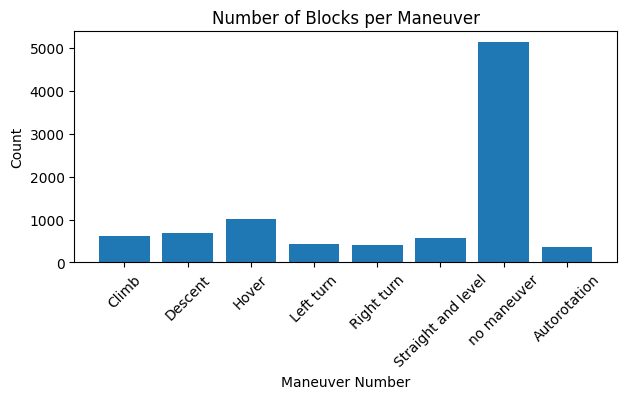

In [34]:
p = plot_maneuver_distribution(df, maneuver_map)
plt.show()

# Model Evaluation Training Data (SVC and PCA)

In [59]:
# Hyper Parameter
K_COUNT = 8
PCA__N_COMPONENTS = 0.9
SVC__C = 10
SVC__GAMMA = 0.01


# Defining feature and target columns
X = df.drop(columns=['maneuver'])
y = df['maneuver']
# Scaling data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Apply PCA (automatically guesses how many dimensions to reduce to)
pca = PCA(n_components=PCA__N_COMPONENTS, svd_solver='full')
X_pca = pca.fit_transform(X_scaled)

# Check explained variance ratio
# print(f"Explained variance by components: {pca.explained_variance_ratio_}")
print("Number of dimensions before PCA: "+str(len(X.columns)))
print("Number of dimensions after PCA: "+str(pca.n_components_))

# Defining the model
model = SVC(C=SVC__C, gamma=SVC__GAMMA, class_weight='balanced')
# Defining k-fold Cross validation
kf = KFold(n_splits=K_COUNT, shuffle=True, random_state=42)
# Train model using cross validation
cv_scores = cross_val_score(model, X_pca, y, cv=kf, scoring='accuracy')
print(f'Cross-validation accuracy scores: {cv_scores}')
print(f'Mean accuracy: {np.mean(cv_scores):.4f}')
print(f'Standard deviation: {np.std(cv_scores):.4f}')

# Predict the labels using cross-validation
y_pred = cross_val_predict(model, X_pca, y, cv=kf)

# Calculate recall
recall = recall_score(y, y_pred, average='macro')
print(f'Recall: {recall:.4f}')

# Confusion matrix
conf_mat = confusion_matrix(y, y_pred)
print("Confusion Matrix:\n", conf_mat)

# 1. Classification Report
print("\nClassification Report:\n", classification_report(y, y_pred))

Number of dimensions before PCA: 342
Number of dimensions after PCA: 33
Cross-validation accuracy scores: [0.85652174 0.86074848 0.86858138 0.85552654 0.85639687 0.87032202
 0.87554395 0.85552654]
Mean accuracy: 0.8624
Standard deviation: 0.0074
Recall: 0.9477
Confusion Matrix:
 [[ 980    0    0    0   21    0    0    0]
 [   0  419    0    0    9    0    0    0]
 [   0    0  558    0   11    0    0    0]
 [   0    0    3  608    2    0    0    0]
 [ 311  107  427  136 3959  102   83    4]
 [   0    0    2    0   10  671    0    0]
 [   0    0    0    0    3    0  413    0]
 [   0    0    0    0   32    2    0  320]]

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.98      0.86      1001
           1       0.80      0.98      0.88       428
           2       0.56      0.98      0.72       569
           3       0.82      0.99      0.90       613
           4       0.98      0.77      0.86      5129
           5       0.87  

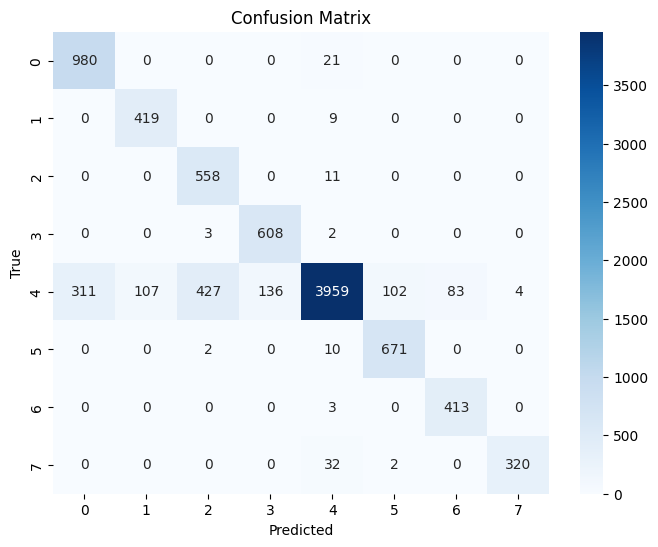

In [60]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

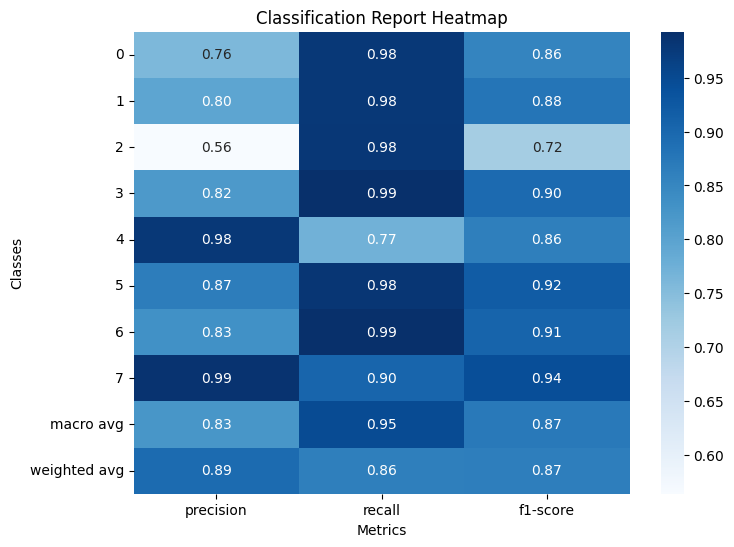

In [61]:
report = classification_report(y, y_pred, output_dict=True)

# Convert the classification report dictionary to a pandas DataFrame
report_df = pd.DataFrame(report).transpose()

# Drop the 'accuracy' row (since it's not relevant for a per-class view)
report_df = report_df.drop('accuracy')

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:, :-1], annot=True, fmt='.2f', cmap='Blues', cbar=True)
plt.title('Classification Report Heatmap')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.show()

In [62]:
model.fit(X_pca, y)
# Predict the labels on the training set
train_pred_labels = model.predict(X_pca)

# Calculate recall on the training set
train_recall = recall_score(y, train_pred_labels, average='macro')
print(f'Training Recall: {train_recall:.4f}')

# Confusion matrix on the training set
train_conf_mat = confusion_matrix(y, train_pred_labels)
print("Training Confusion Matrix:\n", train_conf_mat)

# Classification Report on the training set
train_report = classification_report(y, train_pred_labels)
print("\nTraining Classification Report:\n", train_report)

Training Recall: 0.9742
Training Confusion Matrix:
 [[1000    0    0    0    1    0    0    0]
 [   0  428    0    0    0    0    0    0]
 [   0    0  569    0    0    0    0    0]
 [   0    0    1  612    0    0    0    0]
 [ 259   94  412  116 4098   81   65    4]
 [   0    0    0    0    2  681    0    0]
 [   0    0    0    0    0    0  416    0]
 [   0    0    0    0    0    0    0  354]]

Training Classification Report:
               precision    recall  f1-score   support

           0       0.79      1.00      0.88      1001
           1       0.82      1.00      0.90       428
           2       0.58      1.00      0.73       569
           3       0.84      1.00      0.91       613
           4       1.00      0.80      0.89      5129
           5       0.89      1.00      0.94       683
           6       0.86      1.00      0.93       416
           7       0.99      1.00      0.99       354

    accuracy                           0.89      9193
   macro avg       0.85    

# Model Prediction on Test Data (SVC and PCA)

In [63]:
# this we got from a previous preprocessing step
# list of shared features
SHARED_FEATURES_LIST = ['MotionPlatform_FreezeAndResumeState', 'Ios_FlightAssistance_ClimbRate_Enabled', 'Ios_FlightAssistance_Pedals_Enabled', 'Aerofly_Out_Aircraft_GroundTrack', 'Aerofly_Out_Instrument_PressureAltitude', 'Aerofly_In_Aircraft_WindShearY', 'Aerofly_Out_Aircraft_Hydraulics_MainRotorServo0Pressure', 'Aerofly_Out_Aircraft_AngularVelocity', 'Ios_FlightAssistance_Stable_ForwardFlight', 'Aerofly_Out_Instrument_RadarAltimeter', 'Aerofly_Out_Aircraft_AngleOfAttack', 'Aerofly_Out_Aircraft_Hydraulics_MainRotorServo2Pressure', 'Aerofly_Out_Aircraft_Hydraulics_TailRotorActuatorPressure', 'Ios_FlightAssistance_Stable_Hover', 'Aerofly_Out_Aircraft_PressureAltitude', 'Aerofly_Out_Aircraft_MagneticHeading', 'Aerofly_Out_Aircraft_TrueAltitude', 'Aerofly_Out_Aircraft_Velocity', 'Aerofly_Out_Aircraft_RawAirTemperature', 'Aerofly_Out_Simulation_Fps', 'Aerofly_Running', 'Aerofly_Out_Aircraft_TrueHeading', 'Cls_MainState', 'Aerofly_Out_Aircraft_AirTemperature', 'Hardware_Controls_HelicopterThrottle', 'Aerofly_Out_Instrument_IndicatedAirspeed', 'Aerofly_In_Aircraft_WindShearX', 'Aerofly_Out_Aircraft_VerticalSpeed', 'Aerofly_Out_Aircraft_Latitude', 'Ios_LoadFactor', 'Ios_FlightAssistance_ForwardSpeed_Enabled', 'Aerofly_Out_Aircraft_Gravity', 'Aerofly_Out_Aircraft_Hydraulics_MainRotorServo1Pressure', 'Ios_FlightAssistance_SideSpeed_Enabled', 'Aerofly_Out_Aircraft_Hydraulics_MainLinePressure', 'MotionPlatform_FsmState', 'Aerofly_Out_Aircraft_Pitch', 'Aerofly_Out_Aircraft_Acceleration', 'Aerofly_Out_Instrument_EngineNP', 'Aerofly_Out_Instrument_GeneratorContactorCurrent', 'Aerofly_Out_Simulation_SelectedTriangles', 'Aerofly_Out_Simulation_Time', 'Aerofly_Out_Simulation_Pause', 'Ios_Weight_Fuel', 'Aerofly_Out_Instrument_EngineNR', 'Aerofly_In_Simulation_Fade', 'Ios_GroundHeight', 'Aerofly_Out_Instrument_EngineTorqueFraction', 'Aerofly_Out_Aircraft_GroundSpeed', 'Aerofly_Out_Aircraft_TrueAirspeed', 'MotionPlatform_Running', 'Aerofly_Out_Aircraft_FuelMass', 'maneuver', 'Aerofly_Out_Aircraft_Altitude', 'CLS_U', 'Aerofly_Out_Aircraft_Bank', 'Aerofly_Out_Aircraft_RotorRotationSpeed', 'Aerofly_Out_Aircraft_SideSlip', 'Aerofly_Out_Instrument_FuelFlow', 'Ios_FlightAssistance_Throttle_Enabled', 'PoseTracking_State', 'Aerofly_Out_Aircraft_Longitude', 'Aerofly_Out_Aircraft_Height']
maneuver_map = read_maneuver_map("parsed_data/maneuver_map.json",debug=True)
    
test_df = test_data(SHARED_FEATURES_LIST, BLOCK_SIZE)


Read JSON from parsed_data/maneuver_map.json: {'Hover': 0, 'Left turn': 1, 'Straight and level': 2, 'Climb': 3, 'no maneuver': 4, 'Descent': 5, 'Right turn': 6, 'Autorotation': 7}
['parsed_test_data/f40f71de-5cc2-4719-8a5a-abcf950cbd71.pkl', 'parsed_test_data/0b3f3902-2c04-4625-8576-3bb963e3d709.pkl', 'parsed_test_data/d76bb0eb-bc08-4b35-8c1f-37369452083d.pkl', 'parsed_test_data/663f573a-74c5-4368-b60b-1fb433cd835d.pkl', 'parsed_test_data/a376807a-82d3-4526-b19f-98d4b3f9078b.pkl', 'parsed_test_data/8c36586f-94e9-4ae9-8384-0f3342008677.pkl']


/var/folders/5q/zzd5ty611l59s5c0_xr0tz340000gn/T/ipykernel_7710/3704039702.py:241: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labeled_index, rotation=45)


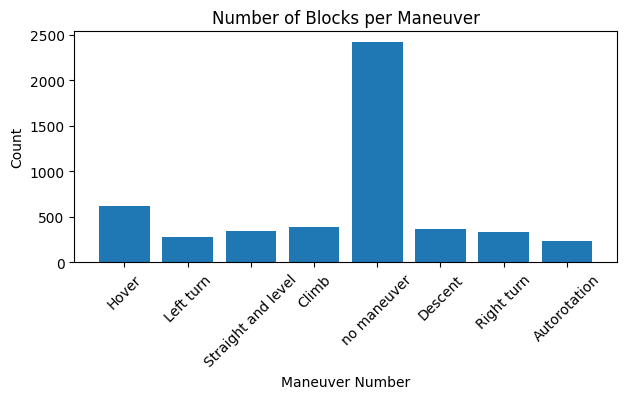

In [64]:
p = plot_maneuver_distribution(test_df, maneuver_map)
plt.show()

In [65]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4976 entries, 0 to 4975
Columns: 343 entries, Mean_MotionPlatform_FreezeAndResumeState to maneuver
dtypes: Float64(298), Int64(29), UInt8(16)
memory usage: 14.1 MB


# Model Evaluation Test Data

In [66]:
# Defining feature and target columns
test_X = test_df.drop(columns=['maneuver'])
test_y = test_df['maneuver']

test_X_scaled = scaler.transform(test_X)
test_X_pca = pca.transform(test_X_scaled)

test_pred_labels = model.predict(test_X_pca)

# Calculate recall on the training set
test_recall = recall_score(test_y, test_pred_labels, average='macro')
print(f'Recall: {test_recall:.4f}')

# Confusion matrix on the training set
test_conf_mat = confusion_matrix(test_y, test_pred_labels)
print("Confusion Matrix:\n", test_conf_mat)

# Classification Report on the training set
test_report = classification_report(test_y, test_pred_labels)
print("\nClassification Report:\n", test_report)

Recall: 0.7820
Confusion Matrix:
 [[ 542    0    0    0   75    0    0    0]
 [   0  259    0    0   15    4    0    0]
 [   2   43  168    0  127    0    3    0]
 [   0    0   13  280  101    0    0    0]
 [ 268   77  148  124 1644  103   51    2]
 [   0    0    0    0   13  330    0   19]
 [   0    0    2    0   77    0  250    0]
 [   0    0    0    0   25    0    0  211]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.67      0.88      0.76       617
         1.0       0.68      0.93      0.79       278
         2.0       0.51      0.49      0.50       343
         3.0       0.69      0.71      0.70       394
         4.0       0.79      0.68      0.73      2417
         5.0       0.76      0.91      0.83       362
         6.0       0.82      0.76      0.79       329
         7.0       0.91      0.89      0.90       236

    accuracy                           0.74      4976
   macro avg       0.73      0.78      0.75      4976


# Custom maneuver recall

In [67]:
def custom_maneuver_recall(y_true, y_pred, maneuver_durations, threshold=0.8):
    detected_maneuvers = 0  # Counter for detected maneuvers
    total_maneuvers = len(maneuver_durations)  # Total number of ground-truth maneuvers
    
    # Iterate through each maneuver
    for maneuver_label, start_idx, end_idx in maneuver_durations:
        # Extract the true and predicted labels for this maneuver duration
        true_labels = y_true[start_idx:end_idx]
        pred_labels = y_pred[start_idx:end_idx]
        
        # Calculate the number of correctly detected blocks
        correct_detections = sum((true_labels == maneuver_label) & (pred_labels == maneuver_label))
        total_duration = len(true_labels)
        
        # Check if the maneuver is detected correctly for at least the threshold percentage
        if correct_detections / total_duration >= threshold:
            detected_maneuvers += 1
    
    # Calculate Maneuver-Recall
    maneuver_recall = detected_maneuvers / total_maneuvers if total_maneuvers > 0 else 0.0
    return maneuver_recall


In [68]:
def create_maneuver_durations(y_true):
    maneuver_durations = []
    start_idx = 0  # Start index of the current maneuver

    for i in range(1, len(y_true)):
        if y_true.iloc[i] != y_true.iloc[start_idx]:
            maneuver_durations.append((y_true.iloc[start_idx], start_idx, i))
            start_idx = i

    maneuver_durations.append((y_true.iloc[start_idx], start_idx, len(y_true)))

    return maneuver_durations

In [69]:
maneuver_durations = create_maneuver_durations(test_y)

recall = custom_maneuver_recall(
    y_true=test_y.values,  # Ground truth labels as an array
    y_pred=test_pred_labels,  # Model predictions
    maneuver_durations=maneuver_durations,  # Maneuver durations
    threshold=0.8  # Detection threshold
)

print(f"Custom Maneuver-Recall: {recall:.4f}")


Custom Maneuver-Recall: 0.5478
